In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import re
import random
import itertools
from tqdm import tqdm
from sklearn.svm import SVC
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/Distributed Analytics/face recognition")

In [3]:
os.chdir('D://face recog')

In [4]:
class image_class():
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
        self.embeddings = []
    def get_len(self):
        return len(self.image_paths)

In [5]:
def get_dataset(path):
    dataset = []
    path_exp = os.path.expanduser(path)
    names = [name for name in os.listdir(path_exp)]
    names.sort()

    for i in range(0,len(names)):
        name = names[i]
        image_paths = []
        facedir = os.path.join(path_exp, name)
        if os.path.isdir(facedir):
            image_paths = [os.path.join(facedir, img) for img in os.listdir(facedir)]
        dataset.append(image_class(name, image_paths))
    return dataset

In [6]:
def read_image(path, img_size = (128,128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    image = image.reshape(1, img_size[0], img_size[1], 3)
    image = image/255
    return image

In [7]:
def get_all_embeddings(model, dataset, img_size=(128,128)):
    for i in range(len(dataset)):
        paths = dataset[i].image_paths
        print(dataset[i].name)
        embeddings = []
        for a in range(0,len(paths)):
            image = read_image(paths[a], img_size=img_size)
            embedding = model(image)
            embeddings.append(embedding)
        dataset[i].embeddings = embeddings
    print('all embeddings calculated')

In [8]:
dataset = get_dataset('lfw/')

In [9]:
TRAIN_TEST_SPLIT = 0.8
train_dataset = dataset[:int(len(dataset)*TRAIN_TEST_SPLIT)]
test_dataset = dataset[int(len(dataset)*TRAIN_TEST_SPLIT):]

In [10]:
for i in range(0,len(dataset)):
    if dataset[i].name == 'Aaron_Sorkin':
        print(dataset[i].image_paths)

['lfw/Aaron_Sorkin\\Aaron_Sorkin_0001.jpg', 'lfw/Aaron_Sorkin\\Aaron_Sorkin_0002.jpg']


In [11]:
class Distance_Layer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def call(self, anchor, pos, neg):
        pos_distance = tf.reduce_sum(tf.square(anchor - pos), -1)
        neg_distance = tf.reduce_sum(tf.square(anchor - neg), -1)
        return (pos_distance, neg_distance)

In [12]:
"""creating the actual network itself, we use imagenet pre trained weights and set most layers as untrainable"""
class FaceNet_Network(tf.keras.Model):
    def __init__(self, input_shape, latent_dims = 128, alpha = 0.2):
        super().__init__()
        self.alpha = alpha
        self.resnet_backbone = tf.keras.applications.resnet50.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=None,
            input_shape=input_shape,
            pooling=None,
            classes=1000,
        )
        
        #trainable = False
        #for layer in self.resnet_backbone.layers:
        #    if layer.name == "conv5_block1_out":
        #        trainable = True
        #        print('trainable')
        #    layer.trainable = trainable

        x_input = tf.keras.Input(input_shape)
        x = self.resnet_backbone(x_input)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        output = tf.keras.layers.Dense(latent_dims)(x)
        
        
        self.embedding_model = tf.keras.Model(inputs = x_input, outputs = output)
        
        anchor = tf.keras.layers.Input(shape = input_shape)
        pos = tf.keras.layers.Input(shape = input_shape)
        neg = tf.keras.layers.Input(shape = input_shape)
        
        anchor_embedding = self.embedding_model(anchor)
        pos_embedding = self.embedding_model(pos)
        neg_embedding = self.embedding_model(neg)
        
        distances = Distance_Layer()(
            anchor_embedding,
            pos_embedding,
            neg_embedding,
        )
        
        self.siamese_model = tf.keras.Model(inputs=[anchor, pos, neg], outputs = distances)
    
    def compute_loss(self, data):
        anchor, pos, neg = data
        anchor = tf.expand_dims(anchor, 0)
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 0)
        pos_distance, neg_distance = self.siamese_model([anchor, pos, neg])
        loss = pos_distance - neg_distance
        loss = tf.maximum(loss + self.alpha, 0.0)
        return loss

In [13]:
test_net = FaceNet_Network((128, 128,3))
test_net.embedding_model.load_weights('facenet_models/facenet_model_3_168.h5')

In [14]:
get_all_embeddings(test_net.embedding_model, dataset)

AJ_Cook
AJ_Lamas
Aaron_Eckhart
Aaron_Guiel
Aaron_Patterson
Aaron_Peirsol
Aaron_Pena
Aaron_Sorkin
Aaron_Tippin
Abba_Eban
Abbas_Kiarostami
Abdel_Aziz_Al-Hakim
Abdel_Madi_Shabneh
Abdel_Nasser_Assidi
Abdoulaye_Wade
Abdul_Majeed_Shobokshi
Abdul_Rahman
Abdulaziz_Kamilov
Abdullah
Abdullah_Ahmad_Badawi
Abdullah_Gul
Abdullah_Nasseef
Abdullah_al-Attiyah
Abdullatif_Sener
Abel_Aguilar
Abel_Pacheco
Abid_Hamid_Mahmud_Al-Tikriti
Abner_Martinez
Abraham_Foxman
Aby_Har-Even
Adam_Ant
Adam_Freier
Adam_Herbert
Adam_Kennedy
Adam_Mair
Adam_Rich
Adam_Sandler
Adam_Scott
Adel_Al-Jubeir
Adelina_Avila
Adisai_Bodharamik
Adolfo_Aguilar_Zinser
Adolfo_Rodriguez_Saa
Adoor_Gopalakarishnan
Adrian_Annus
Adrian_Fernandez
Adrian_McPherson
Adrian_Murrell
Adrian_Nastase
Adriana_Lima
Adriana_Perez_Navarro
Adrianna_Zuzic
Adrien_Brody
Afton_Smith
Agbani_Darego
Agnelo_Queiroz
Agnes_Bruckner
Ahmad_Jbarah
Ahmad_Masood
Ahmed_Ahmed
Ahmed_Chalabi
Ahmed_Ghazi
Ahmed_Ibrahim_Bilal
Ahmed_Lopez
Ahmed_Qureia
Ahmet_Demir
Ahmet_Necdet_Sezer


Bill_Self
Bill_Simon
Bill_Sizemore
Bill_Stapleton
Bill_Stein
Bill_Walton
Billy_Andrade
Billy_Beane
Billy_Bob_Thornton
Billy_Boyd
Billy_Crawford
Billy_Crystal
Billy_Donovan
Billy_Edelin
Billy_Gilman
Billy_Graham
Billy_Joel
Billy_Rork
Billy_Sollie
Billy_Tibbets
Bing_Crosby
Binyamin_Ben-Eliezer
Bison_Dele
Bixente_LIzarazu
Blas_Ople
Blythe_Danner
Blythe_Hartley
Bo_Pelini
Bo_Ryan
Bob_Alper
Bob_Beauprez
Bob_Bowlsby
Bob_Cantrell
Bob_Colvin
Bob_Crippen
Bob_Curtis
Bob_Dole
Bob_Eskridge
Bob_Ferguson
Bob_Geldof
Bob_Goldman
Bob_Graham
Bob_Guccione
Bob_Hartley
Bob_Hayes
Bob_Herz
Bob_Holden
Bob_Hope
Bob_Huggins
Bob_Iger
Bob_Krueger
Bob_Melvin
Bob_Menendez
Bob_Newhart
Bob_Petrino
Bob_Riley
Bob_Stoops
Bob_Sulkin
Bob_Taft
Bob_Wright
Bobby_Bowden
Bobby_Goldwater
Bobby_Jackson
Bobby_Kielty
Bobby_Robson
Bobo_Balde
Bode_Miller
Bonnie_Fuller
Bonnie_Hunt
Bono
Boris_Becker
Boris_Berezovsky
Boris_Henry
Boris_Jordan
Boris_Trajkovski
Boris_Yeltsin
Boutros_Boutros_Ghali
Brad_Alexander_Smith
Brad_Banks
Brad_Browne

Dan_Reeves
Dan_Snyder
Dan_Wheldon
Dana_Vollmer
Daniel_Barenboim
Daniel_Bruehl
Daniel_Chin
Daniel_Coats
Daniel_Comisso_Urdaneta
Daniel_Darnell
Daniel_Day-Lewis
Daniel_Kurtzer
Daniel_Montenegro
Daniel_Montgomery
Daniel_Ortega
Daniel_Osorno
Daniel_Patrick_Moynihan
Daniel_Pearl
Daniel_Radcliffe
Daniel_Rouse
Daniel_Scioli
Daniel_Zelman
Daniela_Cicarelli
Daniela_Hantuchova
Daniele_Bergamin
Daniele_Hypolito
Daniele_Nardello
Daniell_Sunjata
Danielle_Spencer
Danis_Tanovic
Danny_Ainge
Danny_Avalon
Danny_Elfman
Danny_Glover
Danny_Green
Danny_Morgan
Dany_Heatley
Darcy_Regier
Darin_Erstad
Dario_Camuffo
Dario_Franchitti
Dariusz_Michalczewski
Darko_Milicic
Darla_Moore
Darlene_Garrettson
Darrell_Dickey
Darrell_Issa
Darrell_Porter
Darrell_Royal
Darren_Campel
Darren_Clarke
Darryl_McDaniels
Darryl_Stingley
Darvis_Patton
Daryl_Hannah
Daryl_Jones
Daryl_Parks
Daryl_Sabara
Daryl_Smith
Dave_Barr
Dave_Campo
Dave_Johnson
Dave_Lewis
Dave_Matthews
Dave_McGinnis
Dave_McNally
Dave_McNealey
Dave_Odom
Dave_Potter
Dav

Fernando_Velardez
Festus_Mogae
Fidel_Castro
Fidel_Castro_Daiz-Balart
Filip_De_Winter
Filippo_Inzaghi
Filippo_Volandri
Fiona_Milne
Flavia_Delaroli
Flavia_Pennetta
Flor_Montulo
Florecita_Cobian
Florencia_Kirchner
Florencia_Macri
Floyd_Keith
Floyd_Mayweather
Fran_Drescher
Frances_Fisher
Francesco_Totti
Francis_Collins
Francis_Crick
Francis_Ford_Coppola
Francis_George
Francis_Mer
Francis_Ricciardone
Francisco_Flores
Francisco_Garcia
Francisco_Maturana
Francisco_Santos
Francisco_Urenda
Franck_Cerutti
Franco_Cangele
Franco_Dragone
Franco_Frattini
Francois_Botha
Francois_Ozon
Francois_Pienaar
Frank_Abagnale_Jr
Frank_Beamer
Frank_Bell
Frank_Cassell
Frank_Coraci
Frank_Dunham_Jr
Frank_Griswold
Frank_Hilldrup
Frank_Hsieh
Frank_Keating
Frank_Lautenberg
Frank_Marshall
Frank_Murkowski
Frank_Pallone
Frank_Schmoekel
Frank_Shea
Frank_Sinatra
Frank_Solich
Frank_Stallone
Frank_Taylor
Frank_Van_Ecke
Frank_Wycheck
Frank_Zappa
Franklin_Brown
Franklin_Damann
Franko_Simatovic
Franz_Beckenbauer
Franz_Fischler


JC_Chasez
JJ_Redick
JK_Rowling
JP_Suarez
JT_Snow
Jaap_de_Hoop_Scheffer
Jack_Goodman
Jack_Grubman
Jack_Knowlton
Jack_LaLanne
Jack_Nicholson
Jack_Osbourne
Jack_Smith
Jack_Straw
Jack_Valenti
Jack_Welch
Jackie_Chan
Jackie_Dennis
Jackie_Sherrill
Jacky_Cheung
Jacob_Frenkel
Jacqueline_Edwards
Jacqueline_Gold
Jacqueline_Marris
Jacqueline_Obradors
Jacques_Chirac
Jacques_Kallis
Jacques_Rogge
Jacques_Villeneuve
Jada_Pinkett_Smith
Jade_Jagger
Jafar_Umar_Thalib
Jaime_Orti
Jaime_Pressly
Jake_Brace
Jake_Gyllenhaal
Jake_Plummer
Jakob_Kellenberger
Jalal_Talabani
Jalen_Rose
James_Baker
James_Ballenger
James_Barksdale
James_Becker
James_Blake
James_Brazelton
James_Brosnahan
James_Brown
James_Butts
James_Caan
James_Cameron
James_Carville
James_Coburn
James_Collinson
James_Comey
James_Coviello
James_Cunningham
James_Dingemans
James_Franco
James_Gandolfini
James_Gibson
James_Hakett
James_Hallock
James_Harris
James_Hill
James_Hoffa
James_Hughes
James_Ivory
James_Jones
James_Kelly
James_Kirtley
James_Kopp
Jam

Jose_Woldenberg
Joseph_Biden
Joseph_Blatter
Joseph_Deiss
Joseph_Estrada
Joseph_Fiennes
Joseph_Galante
Joseph_Ganim
Joseph_Hoy
Joseph_Kabila
Joseph_LePore
Joseph_Lopez
Joseph_Nacchio
Joseph_Ralston
Joseph_Safra
Joseph_Salgado
Josh_Childress
Josh_Evans
Josh_Kronfeld
Joshua_Davey
Joshua_Gracin
Joshua_Harapko
Joshua_Perper
Joxel_Garcia
Joy_Bryant
Joy_Lee_Sadler
Juan_Antonio_Samaranch
Juan_Carlos
Juan_Carlos_Ferrero
Juan_Carlos_Morales
Juan_Carlos_Ortega
Juan_Fernandez
Juan_Francisco_Palencia
Juan_Ignacio_Chela
Juan_Jose_Lucas
Juan_Manuel_Marquez
Juan_Pablo_Montoya
Juan_Roman_Carrasco
Juan_Roman_Riquelme
Juan_Sanchez
Juan_Valencia_Osorio
Juanes
Judd_Davies
Jude_Law
Judi_Dench
Judi_Patton
Judith_Nathan
Judy_Dean
Judy_Genshaft
Judy_Locy
Judy_Spreckels
Judy_Vassar
Juergen_Braehmer
Juergen_Chrobog
Juergen_Peters
Juergen_Schrempp
Juergen_Trittin
Jules_Asner
Julia_Glass
Julia_Ormond
Julia_Tymoshenko
Julian_Battle
Julian_Fantino
Julianna_Margulies
Julianne_Moore
Julie_Andrews
Julie_Gerberding
Juli

Mahdi_Al_Bassam
Mahendra_Chaudhry
Mahima_Chaudhari
Mahmoud_Abbas
Mahmoud_Al_Zhar
Mahmoud_Diyab_al-Ahmed
Makhdoom_Amin_Fahim
Makiko_Tanaka
Makiya_Ali_Hassan
Malak_Habbak
Malcolm_Glazer
Malcolm_Jamal_Warner
Malcolm_Wild
Malik_Mahmud
Mamdouh_Habib
Manfred_Reyes_Villa
Manfred_Stolpe
Manijeh_Hekmat
Manuel_Gehring
Manuel_Jesus
Manuel_Llorente
Manuel_Pellegrini
Manuel_Poggiali
Manuel_Rosendo
Manuela_Montebrun
Mara_Georges
Marat_Safin
Marc-Andre_Fleury
Marc_Anthony
Marc_Bulger
Marc_Gold
Marc_Grossman
Marc_Leger
Marc_Racicot
Marc_Shaiman
Marcella_Anderson
Marcelo_Bielsa
Marcelo_Ebrard
Marcelo_Rios
Marcelo_Salas
Marcio_de_Souza
Marco_Antonio_Barrera
Marco_Archer_Cardoso_Moreira
Marco_Irizarry
Marco_Pantani
Marcos_Cafu
Marcos_Daniel_Jimenez
Marcos_Milinkovic
Marcus_Allen
Marcus_Garrettson
Marcus_Gronholm
Margaret_Caruso
Margaret_Hasley
Margaret_Hoelzer
Margaret_Okayo
Margaret_Thatcher
Margerry_Bakley
Margie_Puente
Maria_Bello
Maria_Burks
Maria_Callas
Maria_Conchita_Alonso
Maria_Garcia
Maria_Guida

Monique_Garbrecht-Enfeldt
Monte_Kiffin
Moon-So-ri
Morgan_Fairchild
Morgan_Freeman
Morgan_Hentzen
Morris_Dees
Morris_Watts
Moshe_Katsav
Mother_Teresa
Ms_Dynamite
Mstislav_Rostropovich
Muammar_Gaddafi
Muffet_McGraw
Mufti_Mohammad_Syed
Muhammad_Ali
Muhammad_Ibrahim_Bilal
Muhammad_Saeed_al-Sahhaf
Mukesh_Ambani
Mukhtar_Alytnbayev
Munir_Akram
Muwafak_al-Ani
Myung_Yang
Na_Na_Keum
Nabil_Shaath
Nacho_Cabrera_Martin
Nadia_Forte
Nadia_Petrova
Nadine_Vinzens
Naji_Sabri
Najib_al-Salhi
Namuddu_Florence
Nan_Wang
Nancy_Demme
Nancy_Greenlaw
Nancy_Humbert
Nancy_Kerrigan
Nancy_Pelosi
Nancy_Powell
Nancy_Reagan
Nancy_Sinatra
Nancy_Smith
Nanni_Moretti
Naomi_Bronstein
Naomi_Campbell
Naomi_Hayashi
Naomi_Watts
Naoto_Kan
Narayan_Singh_Pun
Narendra_Modi
Nasser_al-Kidwa
Nastassia_Kinski
Nastia_Liukin
Natalia_Dmitrieva
Natalia_Motuziuk
Natalia_Verbeke
Natalia_Vodonova
Natalie_Cole
Natalie_Coughlin
Natalie_Imbruglia
Natalie_Juniardi
Natalie_Maines
Natalie_Stewart
Natalie_Williams
Natalya_Sazanovich
Natanaela_Barnov

Ray_Liotta
Ray_Lucas
Ray_Morrough
Ray_Nagin
Ray_Price
Ray_Romano
Ray_Sherman
Ray_Wasden
Ray_Young
Raymond_Arthurs
Raymond_Odierno
Raza_Rabbani
Razali_Ismail
Rebecca_Romijn-Stamos
Rebekah_Chantay_Revels
Recep_Tayyip_Erdogan
Red_Auerbach
Reese_Witherspoon
Reggie_Lewis
Reggie_Miller
Reggie_Sanders
Regina_Ip
Reginald_Hudlin
Reina_Hayes
Reinhard_Buetikofer
Ren_Qingjin
Rena_Sofer
Renato_Soru
Rene_Antonio_Leon_Rodriguez
Rene_Portland
Renee_Zellweger
Retief_Goosen
Rey_Sanchez
Reyyan_Uzuner
Rhett_Warrener
Rhina_Villatoro
Ricardo_Lagos
Ricardo_Lopez_Murphy
Ricardo_Maduro
Ricardo_Mayorga
Ricardo_Monasterio
Ricardo_Sanchez
Riccardo_Muti
Rich_Brooks
Rich_Gannon
Richard_Armitage
Richard_Barry
Richard_Branson
Richard_Butler
Richard_Carl
Richard_Chamberlain
Richard_Cohen
Richard_Crenna
Richard_Daley
Richard_Dreyfuss
Richard_Fine
Richard_Gephardt
Richard_Gere
Richard_Greenberg
Richard_Haass
Richard_Hamilton
Richard_Harris
Richard_Hellfant
Richard_Jefferson
Richard_Jewell
Richard_Krajicek
Richard_Langil

Stephanie_Zimbalist
Stephen_Ambrose
Stephen_Arigbabu
Stephen_Cooper
Stephen_Covey
Stephen_Crampton
Stephen_Daldry
Stephen_Ebberharter
Stephen_Frears
Stephen_Friedman
Stephen_Funk
Stephen_Glassroth
Stephen_Joseph
Stephen_Keener
Stephen_Oake
Stephen_Push
Stephen_Silas
Stephen_Swindal
Stephen_Thompson
Stephen_Webster
Sterling_Hitchcock
Steve-O
Steve_Alford
Steve_Allan
Steve_Allee
Steve_Austin
Steve_Avery
Steve_Backley
Steve_Ballmer
Steve_Blake
Steve_Blankenship
Steve_Case
Steve_Coogan
Steve_Coterill
Steve_Cox
Steve_Cutler
Steve_Fehr
Steve_Karsay
Steve_Kerr
Steve_Largent
Steve_Lavin
Steve_Lenard
Steve_Mariucci
Steve_McManaman
Steve_Nash
Steve_Nesbitt
Steve_Pagliuca
Steve_Park
Steve_Patterson
Steve_Peace
Steve_Phillips
Steve_Redgrave
Steve_Rush
Steve_Shiver
Steve_Spurrier
Steve_Stirling
Steve_Valentine
Steve_Wariner
Steve_Waugh
Steve_Zahn
Steven_Briggs
Steven_Craig
Steven_Curtis_Chapman
Steven_Feldman
Steven_Hatfill
Steven_Kinlock
Steven_Seagal
Steven_Spielberg
Steven_Tyler
Steven_Van_Zandt

Yang_Pao-yu
Yann_Martel
Yannos_Papantoniou
Yao_Ming
Yasar_Yakis
Yasein_Taher
Yashwant_Sinha
Yasser_Arafat
Yasushi_Akashi
Yasushi_Chimura
Yekaterina_Guseva
Yevgeny_Kafelnikov
Yingfan_Wang
Yishan_Zhang
Yoelbi_Quesada
Yogi_Berra
Yoko_Ono
Yolanda_King
Yoo_Jay-Kun
Yoon_Jeong_Cho
Yoon_Jin-Sik
Yoon_Won-Sik
Yoon_Young-kwan
Yoriko_Kawaguchi
Yory_Boy_Campas
Yoshiyuki_Kamei
Yossi_Beilin
Young_Kim
Yu_Shyi-kun
Yukiko_Okudo
Yukio_Hatoyama
Yuri_Fedotov
Yuri_Luzhkov
Yuri_Malenchenko
Yusaku_Miyazato
Yusuf_Misbac
Yuvraj_Singh
Yves_Brodeur
Zach_Parise
Zach_Pillar
Zach_Safrin
Zafarullah_Khan_Jamali
Zahir_Shah
Zaini_Abdullah
Zakia_Hakki
Zalmay_Khalilzad
Zara_Akhmadova
Zarai_Toledo
Zavad_Zarif
Zdravko_Mucic
Zeljko_Rebraca
Zelma_Novelo
Zeng_Qinghong
Zhang_Wenkang
Zhang_Yimou
Zhang_Ziyi
Zhong_Nanshan
Zhu_Rongji
Zico
Zinedine_Zidane
Ziwang_Xu
Zoe_Ball
Zoran_Djindjic
Zorica_Radovic
Zulfiqar_Ahmed
Zumrati_Juma
Zurab_Tsereteli
Zydrunas_Ilgauskas
all embeddings calculated


In [119]:
def get_embeddings_and_labels(dataset):
    embeddings_flat = []
    labels_flat = []
    for i in range(len(dataset)):
        embeddings_flat += dataset[i].embeddings
        labels_flat += [dataset[i].name] * len(dataset[i].embeddings)
    return embeddings_flat, labels_flat

In [120]:
embeddings, labels = get_embeddings_and_labels(dataset)
embeddings = np.array(embeddings).squeeze()
labels = np.array(labels)

In [121]:
labels.shape

(13236,)

In [122]:
classifier_filename = 'classifier_models/svm.pkl'

In [125]:
def train_classifier(model_filename):
    print('training classifier ...')
    embeddings, labels = get_embeddings_and_labels(dataset)
    embeddings = np.array(embeddings).squeeze()
    labels = np.array(labels)
    model = SVC(kernel='linear', probability=True, decision_function_shape='ovo')
    model.fit(embeddings, labels)
    
    class_names = [ cls.name.replace('_', ' ') for cls in dataset]

    with open(model_filename, 'wb') as outfile:
        pickle.dump((model, class_names), outfile)
    print('Saved classifier model to file "%s"' % model_filename)

In [126]:
train_classifier(classifier_filename)

training classifier ...
Saved classifier model to file "classifier_models/svm.pkl"


In [127]:
"""opening SVC"""
with open(classifier_filename, 'rb') as infile:
        (SVC_model, class_names) = pickle.load(infile)

In [135]:
def classify(image, SVC_model, neural_net):
    embedding = neural_net.embedding_model(image)
    classification = SVC_model.predict_proba(embedding)
    best_class_indices = np.argmax(classification, axis=1)
    best_class_probabilities = classification[np.arange(len(best_class_indices)), best_class_indices]
    for i in range(len(best_class_indices)):
        print('%4d  %s: %.3f' % (i, class_names[best_class_indices[i]], best_class_probabilities[i]))

    #accuracy = np.mean(np.equal(best_class_indices, labels))
    #print('Accuracy: %.3f' % accuracy)
    return best_class_probabilities

In [136]:
def choose_random_file():
    x = random.randint(0,len(dataset))
    name = dataset[x].name
    path = random.choice(dataset[x].image_paths)
    return name, path

In [137]:
test_image = 'test_images/nacho.jpg'
test_image = read_image(test_image)
test_embedding = test_net.embedding_model(test_image)
SVC_guess = SVC_model.predict(test_embedding)
print(SVC_guess[0])
class_prediction = classify(test_image, SVC_model, test_net)

Arnold_Schwarzenegger
   0  Hugo Chavez: 0.007


Duane_Lee_Chapman
   0  George W Bush: 0.041


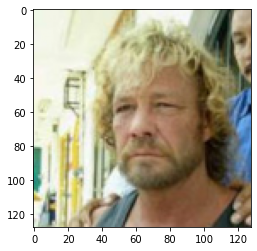

In [146]:
"""example of classification"""
name, path = choose_random_file()
test_image = read_image(path)
plt.imshow(test_image.squeeze())
print(name)
class_prediction = classify(test_image, SVC_model, test_net)

In [36]:
print(class_prediction)

[0.00552081]


In [32]:
print(len(dataset))

5752


In [27]:
print(class_names[class_prediction])

TypeError: only integer scalar arrays can be converted to a scalar index